# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류

* 출처: https://bab2min.tistory.com/642

### 데이터 준비 및 전처리

In [1]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

* https://s3.ap-northeast-2.amazonaws.com/suanlab.com/dataset/GeneralMidi.wav



In [2]:
!wget https://s3.ap-northeast-2.amazonaws.com/suanlab.com/dataset/GeneralMidi.wav

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [3]:
midi_file = './GeneralMidi.wav'

* wmv 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 해당 예제에서는 일부 악기만 선택해서 사용

In [4]:
instruments = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
num_notes = 50
sec = 2

audio = []
inst = []

for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument * num_notes * sec) + (note * sec)
  print('instrument: {}, note: {}, offset: {}'.format(instrument, note, offset))

  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=2.0)
  audio.append(y)
  inst.append(inst_idx)

instrument: 0, note: 0, offset: 0


C:\Users\020\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: './GeneralMidi.wav'

In [5]:
import numpy as np

audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.float32)

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


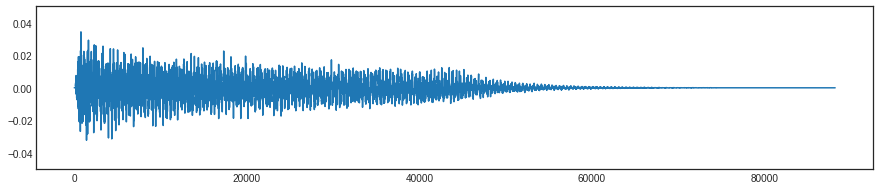

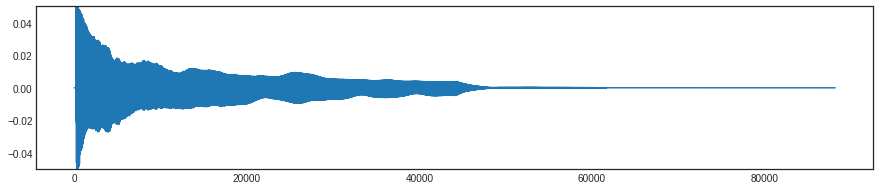

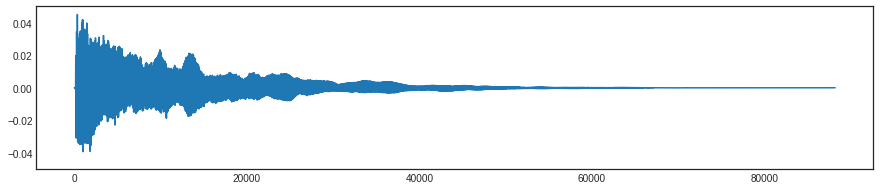

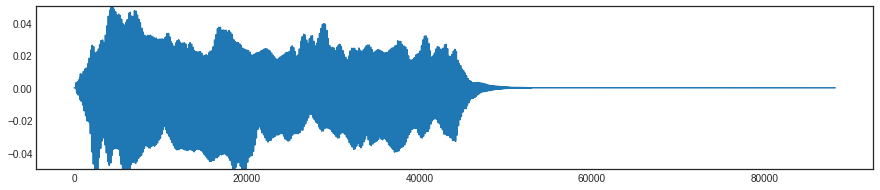

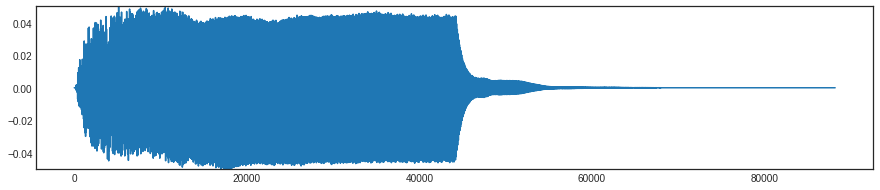

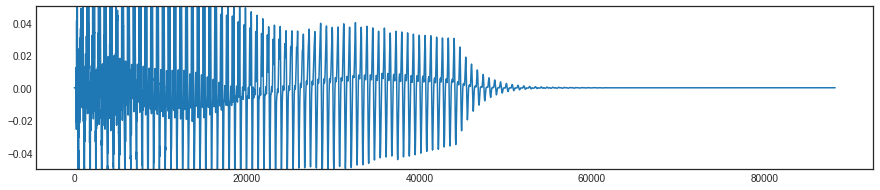

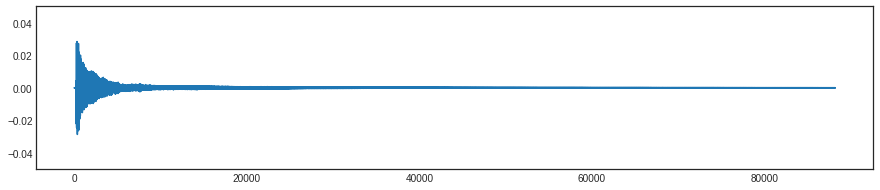

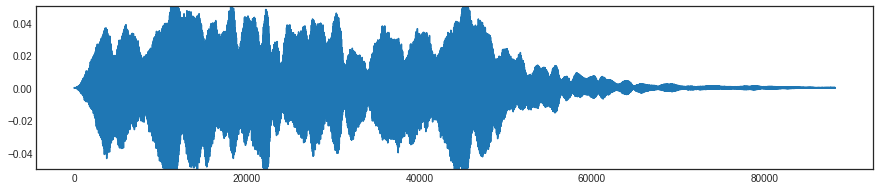

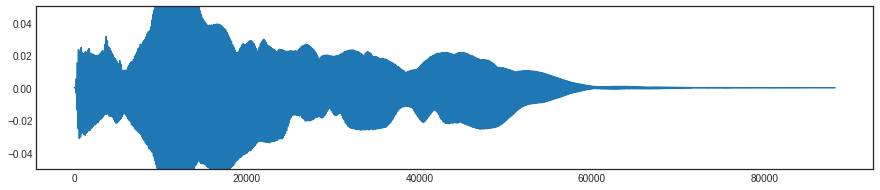

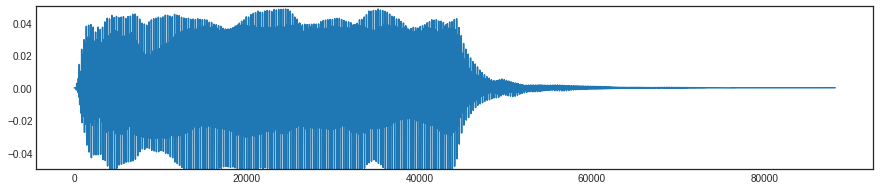

In [6]:
for idx in range(0, len(audio_np), num_notes):
  plt.figure(figsize=(15, 3))
  plt.plot(audio_np[idx])
  plt.ylim([-0.05, 0.05])
  plt.show()

In [7]:
print(inst_np[0])
ipd.Audio(audio_np[0], rate=sr)

0.0


In [8]:
print(inst_np[50])
ipd.Audio(audio_np[50], rate=sr)

1.0


In [9]:
print(inst_np[100])
ipd.Audio(audio_np[100], rate=sr)

2.0


In [10]:
print(inst_np[150])
ipd.Audio(audio_np[150], rate=sr)

3.0


In [11]:
print(inst_np[200])
ipd.Audio(audio_np[200], rate=sr)

4.0


## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 88200)
(100, 88200)
(400,)
(100,)


### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.09


### Support Vector Machine

In [15]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.08


### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.36


## Constant-Q를 이용한 머신러닝 오디오 분류

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음 (음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도) 음악을 처리하는 데에 푸리에 변환보다 유리

*   주파수 대역을 저장할 리스트 `audio_cqt` 선언
*   constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
*   해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음
*   여기서는 Constant-Q 변환을 사용해 오디오 데이터를 주파수 대역으로 변환




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [17]:
audio_cqt = []

for y in audio:
  ret = librosa.cqt(y, sr, hop_length=1024, n_bins=24*7, bins_per_octave=24)
  ret = np.abs(ret)
  audio_cqt.append(ret)

* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1155: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


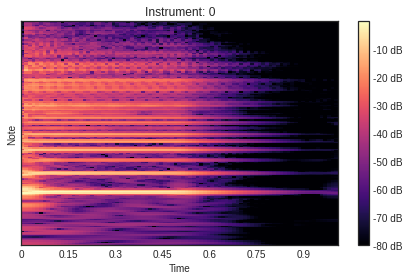

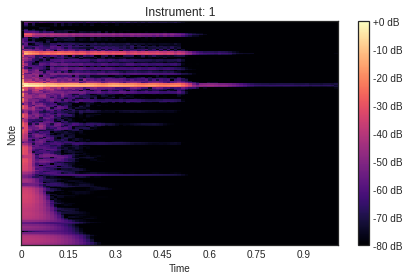

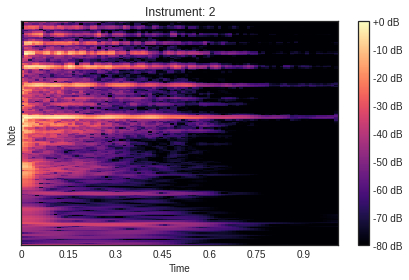

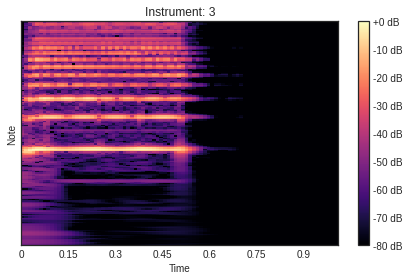

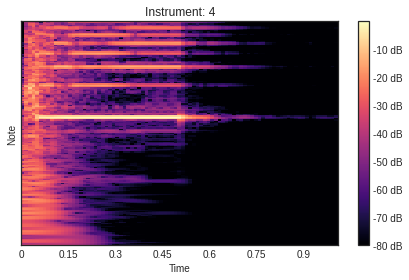

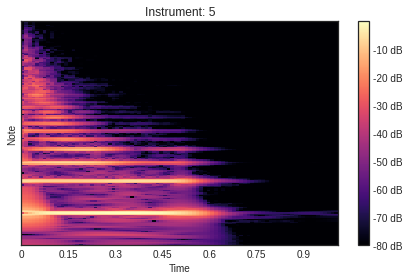

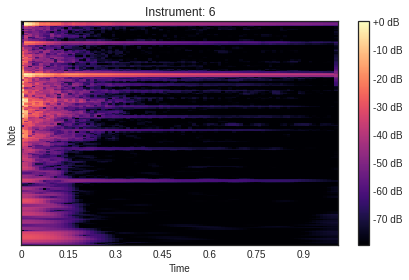

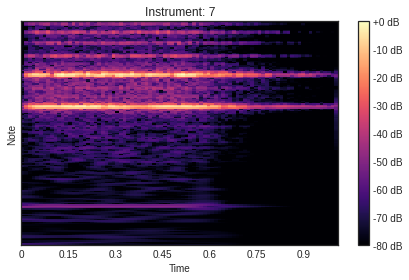

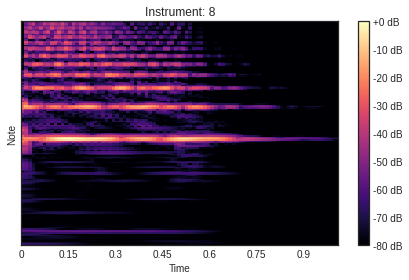

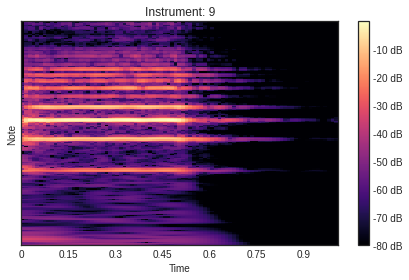

In [18]:
for i in range(0, len(instruments) * num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

* 훈련 데이터와 실험 데이터를 분리



*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [19]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)




*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [20]:
cqt_np = cqt_np.reshape((500, 168 * 87))

* 학습 데이터와 실험 데이터를 분리

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(cqt_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616)
(100, 14616)
(400,)
(100,)


### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.33


### Support Vector Machine

In [24]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.33


### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.65


## Constant-Q 특징을 이용한 딥러닝 오디오 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [26]:
from keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_np = cqt_np.reshape((500, 168 * 87))
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616, 1)
(100, 14616, 1)
(400, 10)
(100, 10)


In [27]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(14616, ), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [28]:
model = model_build()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14616)]           0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               7483904   
_________________________________________________________________
hidden2 (Dense)              (None, 256)               131328    
_________________________________________________________________
hidden3 (Dense)              (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 7,649,418
Trainable params: 7,649,418
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 3s 295ms/step - loss: 2.2492 - acc: 0.1656 - val_loss: 2.1252 - val_acc: 0.2375
Epoch 2/30
3/3 [==============================] - 0s 31ms/step - loss: 1.8484 - acc: 0.4875 - val_loss: 2.0541 - val_acc: 0.2375
Epoch 3/30
3/3 [==============================] - 0s 32ms/step - loss: 1.4893 - acc: 0.5773 - val_loss: 2.0344 - val_acc: 0.2375
Epoch 4/30
3/3 [==============================] - 0s 32ms/step - loss: 1.1570 - acc: 0.6777 - val_loss: 1.9820 - val_acc: 0.2625
Epoch 5/30
3/3 [==============================] - 0s 32ms/step - loss: 0.9272 - acc: 0.7641 - val_loss: 2.1598 - val_acc: 0.2625
Epoch 6/30
3/3 [==============================] - 0s 31ms/step - loss: 0.7601 - acc: 0.7932 - val_loss: 2.4427 - val_acc: 0.2500
Epoch 7/30
3/3 [==============================] - 0s 34ms/step - loss: 0.5685 - acc: 0.8430 - val_loss: 2.4794 - val_acc: 0.2750
Epoch 8/30
3/3 [==============================] - 0s 35ms/step - loss: 0.4831 - acc: 0.8596 - va

In [30]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(14, 5))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r:', label='validation_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, acc, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_acc, 'r:', label='validation_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Auccracy')
  ax2.grid()
  ax2.legend()

  plt.show()

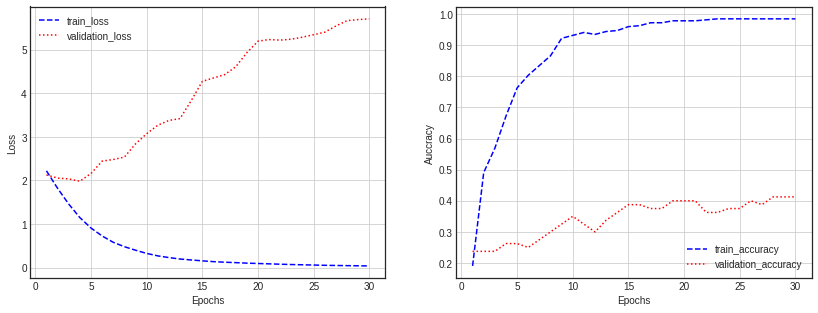

In [31]:
plot_history(history.history)

In [32]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 5ms/step - loss: 4.8670 - acc: 0.4000


[4.866974353790283, 0.4000000059604645]

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [33]:
from keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 168, 87, 1)
(100, 168, 87, 1)
(400, 10)
(100, 10)


In [34]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

def model_build():
  model = Sequential()

  input = Input(shape=(168, 87, 1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [35]:
model = model_build()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 87, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 168, 87, 128)      1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 44, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 44, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 22, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 22, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 11, 512)       0   

In [36]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 52s 6s/step - loss: 2.2700 - acc: 0.1078 - val_loss: 1.9276 - val_acc: 0.3375
Epoch 2/30
3/3 [==============================] - 2s 539ms/step - loss: 1.8951 - acc: 0.3045 - val_loss: 1.5179 - val_acc: 0.4000
Epoch 3/30
3/3 [==============================] - 2s 540ms/step - loss: 1.2454 - acc: 0.5242 - val_loss: 1.3980 - val_acc: 0.5125
Epoch 4/30
3/3 [==============================] - 2s 547ms/step - loss: 0.8170 - acc: 0.7102 - val_loss: 0.8679 - val_acc: 0.7000
Epoch 5/30
3/3 [==============================] - 2s 547ms/step - loss: 0.5337 - acc: 0.8451 - val_loss: 0.9100 - val_acc: 0.6625
Epoch 6/30
3/3 [==============================] - 2s 540ms/step - loss: 0.5125 - acc: 0.8098 - val_loss: 1.1678 - val_acc: 0.7125
Epoch 7/30
3/3 [==============================] - 2s 547ms/step - loss: 0.4952 - acc: 0.8551 - val_loss: 0.6650 - val_acc: 0.7500
Epoch 8/30
3/3 [==============================] - 2s 543ms/step - loss: 0.2227 - acc: 0.9227

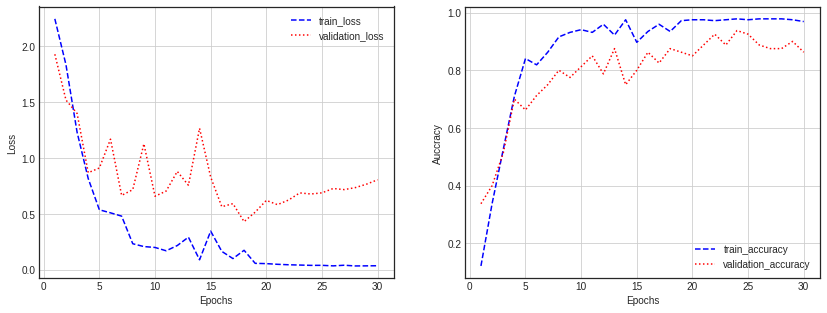

In [37]:
plot_history(history.history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [38]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 2s 163ms/step - loss: 0.5549 - acc: 0.9200


[0.5549347400665283, 0.9200000166893005]

## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [39]:
audio_mfcc = []

for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr)
  audio_mfcc.append(ret)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0, flags=flags)


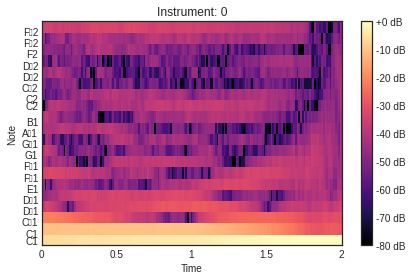

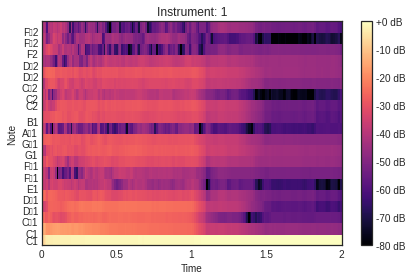

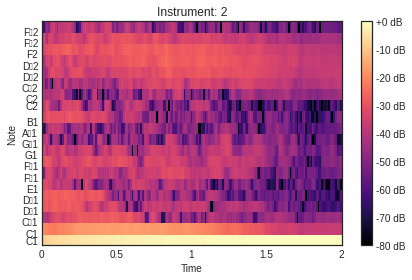

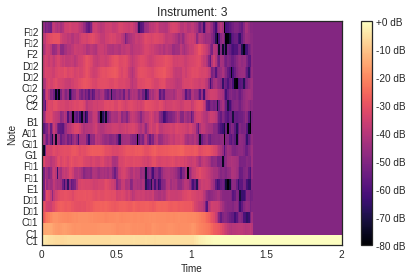

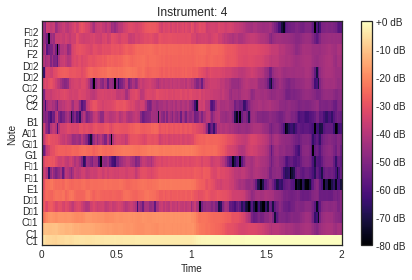

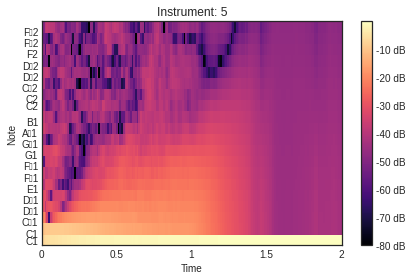

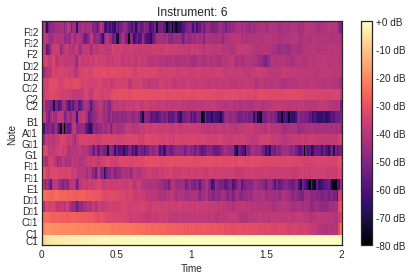

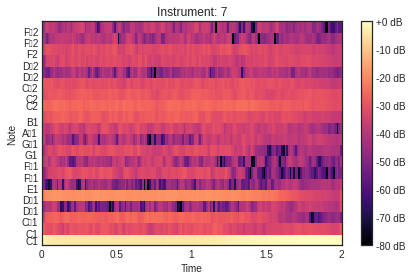

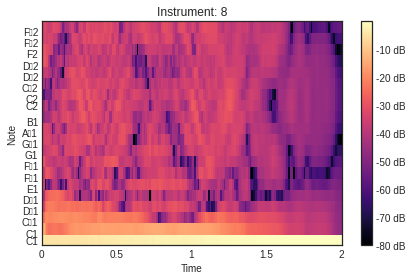

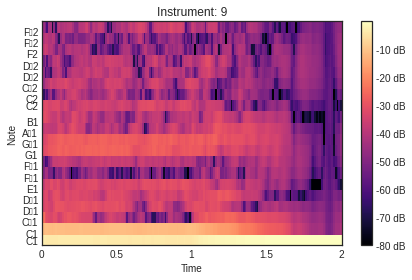

In [40]:
for i in range(0, len(instruments) * num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

In [41]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)

(500, 20, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [42]:
mfcc_np = mfcc_np.reshape((500, 20 * 173))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler(copy=True, feature_range=(0, 1))

* 학습 데이터와 실험 데이터를 분리

In [44]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(mfcc_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3460)
(100, 3460)
(400,)
(100,)


### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.97


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Support Vector Machine

In [46]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.97


### Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

0.87


## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [48]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_np = mfcc_np.reshape((500, 20 * 173))
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3460, 1)
(100, 3460, 1)
(400, 10)
(100, 10)


In [49]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(3460, ), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [50]:
model = model_build()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3460)]            0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               1772032   
_________________________________________________________________
hidden2 (Dense)              (None, 256)               131328    
_________________________________________________________________
hidden3 (Dense)              (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,937,546
Trainable params: 1,937,546
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 1s 119ms/step - loss: 274.4492 - acc: 0.1051 - val_loss: 313.9143 - val_acc: 0.0875
Epoch 2/30
3/3 [==============================] - 0s 24ms/step - loss: 276.0249 - acc: 0.1088 - val_loss: 211.2682 - val_acc: 0.1875
Epoch 3/30
3/3 [==============================] - 0s 25ms/step - loss: 154.2464 - acc: 0.2711 - val_loss: 126.7765 - val_acc: 0.2000
Epoch 4/30
3/3 [==============================] - 0s 22ms/step - loss: 80.7768 - acc: 0.3277 - val_loss: 48.2487 - val_acc: 0.2625
Epoch 5/30
3/3 [==============================] - 0s 30ms/step - loss: 50.6176 - acc: 0.2385 - val_loss: 51.6649 - val_acc: 0.3000
Epoch 6/30
3/3 [==============================] - 0s 29ms/step - loss: 44.7430 - acc: 0.3051 - val_loss: 26.7901 - val_acc: 0.2875
Epoch 7/30
3/3 [==============================] - 0s 22ms/step - loss: 22.4439 - acc: 0.3791 - val_loss: 32.7273 - val_acc: 0.3375
Epoch 8/30
3/3 [==============================] - 0s 25ms/step - loss: 22.64

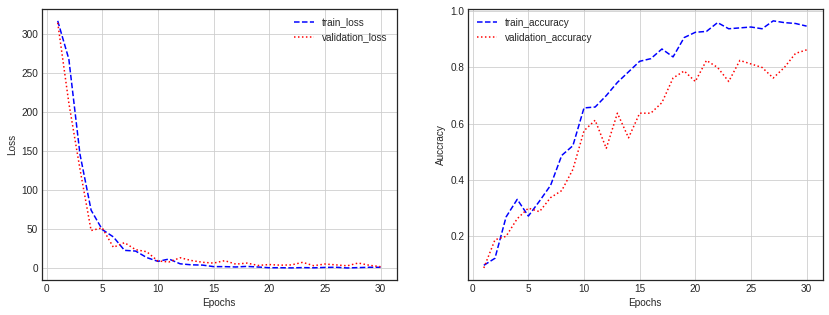

In [52]:
plot_history(history.history)

In [53]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 4ms/step - loss: 1.3914 - acc: 0.9400


[1.3913744688034058, 0.9399999976158142]

### CNN 모델 구성

In [54]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 20, 173, 1)
(100, 20, 173, 1)
(400, 10)
(100, 10)


In [55]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

def model_build():
  model = Sequential()

  input = Input(shape=(20, 173, 1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [56]:
model = model_build()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 173, 1)]      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 173, 128)      1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 87, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 87, 256)       295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 44, 256)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 44, 512)        1180160   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 22, 512)        0   

In [57]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 6s 2s/step - loss: 52.3357 - acc: 0.1332 - val_loss: 33.6261 - val_acc: 0.1000
Epoch 2/30
3/3 [==============================] - 1s 175ms/step - loss: 25.9273 - acc: 0.1010 - val_loss: 3.2532 - val_acc: 0.0875
Epoch 3/30
3/3 [==============================] - 1s 173ms/step - loss: 2.8444 - acc: 0.1209 - val_loss: 2.2302 - val_acc: 0.1750
Epoch 4/30
3/3 [==============================] - 1s 174ms/step - loss: 2.1856 - acc: 0.1732 - val_loss: 2.0931 - val_acc: 0.2000
Epoch 5/30
3/3 [==============================] - 1s 173ms/step - loss: 1.8985 - acc: 0.3455 - val_loss: 1.9563 - val_acc: 0.3250
Epoch 6/30
3/3 [==============================] - 1s 171ms/step - loss: 1.6312 - acc: 0.4086 - val_loss: 1.6048 - val_acc: 0.4000
Epoch 7/30
3/3 [==============================] - 1s 175ms/step - loss: 1.3337 - acc: 0.5486 - val_loss: 1.3649 - val_acc: 0.5000
Epoch 8/30
3/3 [==============================] - 1s 170ms/step - loss: 0.9499 - acc: 0.69

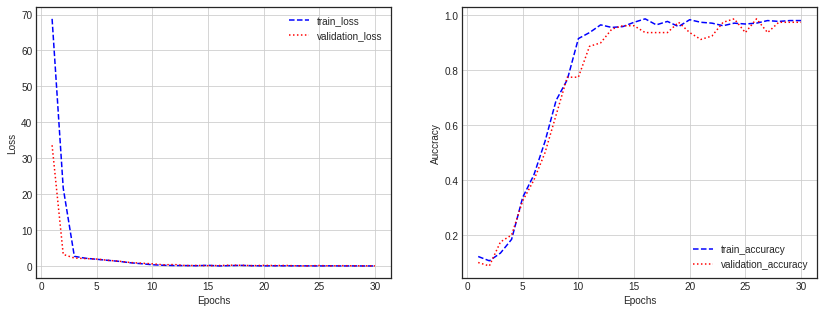

In [58]:
plot_history(history.history)

In [59]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 1s 71ms/step - loss: 0.0679 - acc: 0.9900


[0.06787955015897751, 0.9900000095367432]

In [61]:
predictions = model.predict(test_x)[:10]
print(len(predictions))

10


In [63]:
for i in range(len(predictions)):
    print('Model Prediction: {}\nTrue label: {}'.format(np.argmax(predictions[i]), test_y[i]))

Model Prediction: 5
True label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Model Prediction: 1
True label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Model Prediction: 8
True label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Model Prediction: 2
True label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Model Prediction: 5
True label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Model Prediction: 5
True label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Model Prediction: 1
True label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Model Prediction: 7
True label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Model Prediction: 1
True label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Model Prediction: 9
True label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
